# NLP Modeling Lesson

In this lesson, we'll do a bit of feature engineering, and then model our text data. We'll be aiming to predict whether a given text message is spam or not, and trying to predict the category of news articles.
>### Turning our text data into numeric values we can pass into our model
- Our models only see `potatoes`
- Finding the hidden trend in our data and using it to make predictions

## Feature Extraction: TF-IDF
- **TF**: Term Frequency; how often a particular word appears in a document. 

        "apple" appears in this document 15 times
- **IDF**: Inverse Document Frequency; a measure of how many (related) documents contain a particular word. 

        "apple" is found in 10 of the 58 documents in our sample
        
- **TF-IDF**: A combination of the two measures above.

### TF: Term Frequency

Term frequency can be calculated in a number of ways, all of which reflect how frequently a word appears in a document.

- **Raw Count**: This is simply the count of the number of occurances of each word.
- **Frequency**: The number of times each word appears divided by the total number of words.
- **Augmented Frequency**: The frequency of each word divided by the maximum frequency. This can help prevent bias towards larger documents.

Let's take a look at an example:

In [1]:
from pprint import pprint

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from prepare import basic_clean, lemmatize

In [2]:
document = 'Mary had a little lamb, a little lamb, a little lamb.'
document

'Mary had a little lamb, a little lamb, a little lamb.'

In [3]:
# clean up the text, lower and remove punctuation
document = document.lower().replace(',', '').replace('.', '')
document

'mary had a little lamb a little lamb a little lamb'

In [4]:
# transform into a series
pd.Series(document.split())

0       mary
1        had
2          a
3     little
4       lamb
5          a
6     little
7       lamb
8          a
9     little
10      lamb
dtype: object

In [5]:
words = pd.Series(document.split())
words

0       mary
1        had
2          a
3     little
4       lamb
5          a
6     little
7       lamb
8          a
9     little
10      lamb
dtype: object

From the series we can extract the value_counts, which is our raw count for term frequency. Once we have the raw counts, we can calculate the other measures.

In [6]:
words.value_counts()

little    3
a         3
lamb      3
had       1
mary      1
dtype: int64

In [7]:
lullaby = pd.DataFrame({'raw_count':words.value_counts()})
lullaby

raw_count
little          3
a               3
lamb            3
had             1
mary            1

In [11]:
words.value_counts(normalize = True)

little    0.272727
a         0.272727
lamb      0.272727
had       0.090909
mary      0.090909
dtype: float64

In [8]:
lullaby['frequency'] = lullaby.raw_count.apply(lambda x: x/lullaby.raw_count.sum())
lullaby

raw_count  frequency
little          3   0.272727
a               3   0.272727
lamb            3   0.272727
had             1   0.090909
mary            1   0.090909

In [12]:
lullaby['augmented_frequency'] = lullaby.frequency.apply(lambda x: x/lullaby.frequency.max())
lullaby

raw_count  frequency  augmented_frequency
little          3   0.272727             1.000000
a               3   0.272727             1.000000
lamb            3   0.272727             1.000000
had             1   0.090909             0.333333
mary            1   0.090909             0.333333

In [17]:
# We can accomplish the same task using fewer computational resources using .assign
(pd.DataFrame({'raw_count': words.value_counts()})
 .assign(frequency = lambda df: df.raw_count / df.raw_count.sum())
 .assign(augmented_frequency = lambda df: df.frequency / df.frequency.max()))

raw_count  frequency  augmented_frequency
little          3   0.272727             1.000000
a               3   0.272727             1.000000
lamb            3   0.272727             1.000000
had             1   0.090909             0.333333
mary            1   0.090909             0.333333

**Takeaways**: These are simply numeric representations of one characteristic of the strings in our corpus (frequency). Aside from simply showing us that some words are more frequent than others, this information by itself doesn't provide us much value. 

## IDF: Inverse Document Frequency

Inverse Document Frequency also provides information about individual words, but, in order to use this measure, we must have multiple documents, i.e. several different bodies of text.

Inverse Document Frequency tells us how much **information** a word provides. 
>A measurement of the predictive quality of a word. 

It is based on how commonly a word appears across multiple documents. The metric is divised such that the more frequently a word appears, the lower the IDF for that word will be.

      idf(word) = log(# of documents / # of documents containing word)
      
> If a given word doesn't appear in any documents, the denominator in the equation above would be zero, so some definitions of idf will add 1 to the denominator.

For example, imagine we have 20 documents. We can visualize what the idf score looks like with the code below:

Text(0.5, 1.0, 'IDF for a given word')

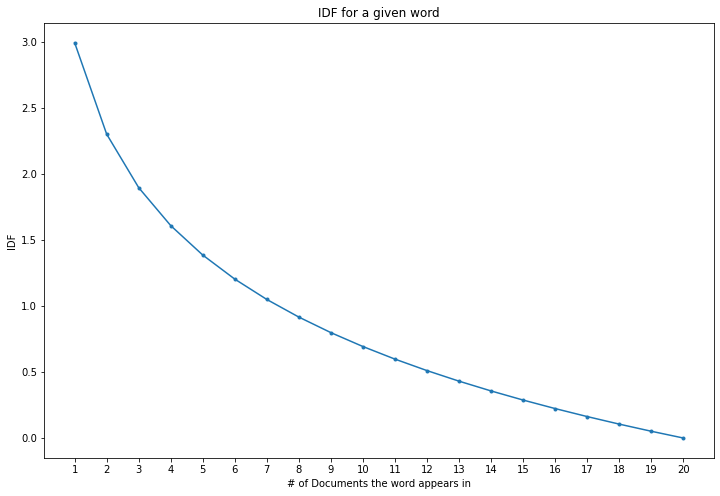

In [18]:
n_documents = 20

x = np.arange(1, n_documents + 1)
y = np.log(n_documents / x)

plt.figure(figsize=(12, 8))
plt.plot(x, y, marker='.')

plt.xticks(x)
plt.xlabel('# of Documents the word appears in')
plt.ylabel('IDF')
plt.title('IDF for a given word')

**Takeaways**: Suppose you are trying to create a model that predicts whether a given corpus is written before 1900 or after 1900. If a word appears in every document of your sample, its not going to provide much insight. But if a word only appears in a small number of documents, then it could be representative of an underlying trend (i.e. "afternoonified" shows up in a small number of documents all of which were written before 1900).

    High IDF = More information

Let's look at an example of calculating IDF:

In [20]:
# our 3 example documents
documents = {
    'news': 'Codeup announced last thursday that they just launched a new data science program. It is 18 weeks long.',
    'description': 'Codeup\'s data science program teaches hands on skills using Python and pandas.',
    'context': 'Codeup\'s data science program was created in response to a percieved lack of data science talent, and growing demand.'
}
documents

{'news': 'Codeup announced last thursday that they just launched a new data science program. It is 18 weeks long.',
 'description': "Codeup's data science program teaches hands on skills using Python and pandas.",
 'context': "Codeup's data science program was created in response to a percieved lack of data science talent, and growing demand."}

In [21]:
pprint(documents)

{'context': "Codeup's data science program was created in response to a "
            'percieved lack of data science talent, and growing demand.',
 'description': "Codeup's data science program teaches hands on skills using "
                'Python and pandas.',
 'news': 'Codeup announced last thursday that they just launched a new data '
         'science program. It is 18 weeks long.'}


In [22]:
print('\nCleaning and lemmatizing...\n')

documents = {topic: lemmatize(basic_clean(documents[topic])) for topic in documents}
pprint(documents)


Cleaning and lemmatizing...

{'context': "codeup's data science program wa created in response to a "
            'percieved lack of data science talent and growing demand',
 'description': "codeup's data science program teach hand on skill using "
                'python and panda',
 'news': 'codeup announced last thursday that they just launched a new data '
         'science program it is 18 week long'}


In [23]:
# Visualize document values to help explain our upcoming idf function
documents.values()

dict_values(['codeup announced last thursday that they just launched a new data science program it is 18 week long', "codeup's data science program teach hand on skill using python and panda", "codeup's data science program wa created in response to a percieved lack of data science talent and growing demand"])

### Note that this function relies on a globally defined documents variable.

In [25]:
def idf(word):
    '''A simple way to calculate idf for demonstration. Note that this 
    function relies on a globally defined documents variable.'''
    n_occurences = sum([1 for doc in documents.values() if word in doc])
    
    return len(documents) / n_occurences

In [32]:
documents.values()

dict_values(['codeup announced last thursday that they just launched a new data science program it is 18 week long', "codeup's data science program teach hand on skill using python and panda", "codeup's data science program wa created in response to a percieved lack of data science talent and growing demand"])

In [35]:
sum(2 for doc in documents.values())

6

In [37]:
len(documents.values())

3

In [39]:
# combining the elements in the list
' '.join(documents.values())

"codeup announced last thursday that they just launched a new data science program it is 18 week long codeup's data science program teach hand on skill using python and panda codeup's data science program wa created in response to a percieved lack of data science talent and growing demand"

In [40]:
# splitting each word, creating a list of word strings
' '.join(documents.values()).split()

['codeup',
 'announced',
 'last',
 'thursday',
 'that',
 'they',
 'just',
 'launched',
 'a',
 'new',
 'data',
 'science',
 'program',
 'it',
 'is',
 '18',
 'week',
 'long',
 "codeup's",
 'data',
 'science',
 'program',
 'teach',
 'hand',
 'on',
 'skill',
 'using',
 'python',
 'and',
 'panda',
 "codeup's",
 'data',
 'science',
 'program',
 'wa',
 'created',
 'in',
 'response',
 'to',
 'a',
 'percieved',
 'lack',
 'of',
 'data',
 'science',
 'talent',
 'and',
 'growing',
 'demand']

In [42]:
# getting each unique string word
pd.Series(' '.join(documents.values()).split()).unique()

array(['codeup', 'announced', 'last', 'thursday', 'that', 'they', 'just',
       'launched', 'a', 'new', 'data', 'science', 'program', 'it', 'is',
       '18', 'week', 'long', "codeup's", 'teach', 'hand', 'on', 'skill',
       'using', 'python', 'and', 'panda', 'wa', 'created', 'in',
       'response', 'to', 'percieved', 'lack', 'of', 'talent', 'growing',
       'demand'], dtype=object)

In [43]:
# Get a list of the unique words
unique_words = pd.Series(' '.join(documents.values()).split()).unique()
unique_words

array(['codeup', 'announced', 'last', 'thursday', 'that', 'they', 'just',
       'launched', 'a', 'new', 'data', 'science', 'program', 'it', 'is',
       '18', 'week', 'long', "codeup's", 'teach', 'hand', 'on', 'skill',
       'using', 'python', 'and', 'panda', 'wa', 'created', 'in',
       'response', 'to', 'percieved', 'lack', 'of', 'talent', 'growing',
       'demand'], dtype=object)

In [44]:
pd.DataFrame(unique_words)

0
0      codeup
1   announced
2        last
3    thursday
4        that
5        they
6        just
7    launched
8           a
9         new
10       data
11    science
12    program
13         it
14         is
15         18
16       week
17       long
18   codeup's
19      teach
20       hand
21         on
22      skill
23      using
24     python
25        and
26      panda
27         wa
28    created
29         in
30   response
31         to
32  percieved
33       lack
34         of
35     talent
36    growing
37     demand

In [45]:
pd.DataFrame(dict(word = unique_words))

word
0      codeup
1   announced
2        last
3    thursday
4        that
5        they
6        just
7    launched
8           a
9         new
10       data
11    science
12    program
13         it
14         is
15         18
16       week
17       long
18   codeup's
19      teach
20       hand
21         on
22      skill
23      using
24     python
25        and
26      panda
27         wa
28    created
29         in
30   response
31         to
32  percieved
33       lack
34         of
35     talent
36    growing
37     demand

In [46]:
# put the unique words into a data frame
(pd.DataFrame(dict(word=unique_words))
 # calculate the idf for each word
 .assign(idf=lambda df: df.word.apply(idf))
 # sort the data for presentation purposes
 .set_index('word')
 .sort_values(by='idf', ascending=False))

idf
word          
teach      3.0
created    3.0
hand       3.0
skill      3.0
using      3.0
python     3.0
panda      3.0
wa         3.0
response   3.0
long       3.0
to         3.0
percieved  3.0
lack       3.0
of         3.0
talent     3.0
growing    3.0
announced  3.0
demand     3.0
new        3.0
launched   3.0
18         3.0
last       3.0
is         3.0
it         3.0
thursday   3.0
that       3.0
they       3.0
just       3.0
week       3.0
codeup's   1.5
in         1.5
and        1.5
a          1.0
data       1.0
science    1.0
program    1.0
on         1.0
codeup     1.0

**Takeaways**: Words with the lowest IDF score were found in every document. They do us no good in helping us to distinguish whether a given corpus was "context", "description", or "news". Words with high IDF scores are more strongly linked to a particular classification. 

But this sample is so small that we should be cautious in using the word "on" as a means to classify a future corpus. 

> The calculation for an individual IDF score requires a word **and** a set of documents.

## TF-IDF

TF-IDF is simply the multiplication of the two metrics we've discussed above. Let's calculate an TF-IDF for all of the words and documents:

In [47]:
# We will create an empty list to store values for us as we iterate through our data
tfs = []

# Start by iterating over all the documents. We can use .items() to speed up our loop:
documents.items()

dict_items([('news', 'codeup announced last thursday that they just launched a new data science program it is 18 week long'), ('description', "codeup's data science program teach hand on skill using python and panda"), ('context', "codeup's data science program wa created in response to a percieved lack of data science talent and growing demand")])

In [48]:
# Create a for loop
for doc, text in documents.items():
    # We will make a dataframe that contains the term frequency for every word
    df = (pd.Series(text.split())
          .value_counts()
          .reset_index()
          .set_axis(['word', 'raw_count'], axis=1, inplace=False)
          .assign(tf=lambda df: df.raw_count / df.shape[0])
          .drop(columns='raw_count')
          .assign(doc=doc))
    # Then add that data frame to our list
    tfs.append(df)

In [51]:
tfs

[         word        tf   doc
 0     science  0.055556  news
 1     program  0.055556  news
 2         new  0.055556  news
 3          is  0.055556  news
 4    launched  0.055556  news
 5      codeup  0.055556  news
 6        week  0.055556  news
 7        last  0.055556  news
 8   announced  0.055556  news
 9    thursday  0.055556  news
 10         it  0.055556  news
 11       just  0.055556  news
 12         18  0.055556  news
 13       long  0.055556  news
 14       data  0.055556  news
 15       that  0.055556  news
 16          a  0.055556  news
 17       they  0.055556  news,
         word        tf          doc
 0    science  0.083333  description
 1    program  0.083333  description
 2        and  0.083333  description
 3       hand  0.083333  description
 4       data  0.083333  description
 5         on  0.083333  description
 6      skill  0.083333  description
 7   codeup's  0.083333  description
 8      using  0.083333  description
 9      panda  0.083333  description
 10

In [52]:
# What actually happened in that code block? Overexplanation using print statements:
print("BEGINNING LOOP")
print("\n")
for doc, text in documents.items():
    print("Text being manipulated:")
    print('-----------------------------------------')
    print(f'Document: {doc}')
    print(f'Text: {text}')
    print('\n')
    print("Step 1: Splitting the corpus into a list of words")
    print("df = (pd.Series(text.split()))")
    print('-----------------------------------------')
    df = (pd.Series(text.split()))
    print(df)
    print('\n')
    
    print("Step 2: Converting list of words into a value count array")
    print("df = df.value_counts()")
    print('-----------------------------------------')
    df = df.value_counts()
    print(df)
    print('\n')
    
    print("Step 3: Resetting the index")
    print("df = df.reset_index()")
    print('-----------------------------------------')
    df = df.reset_index()
    print(df)
    print('\n')
    
    print("Step 4: Relabeling the columns")
    print("df = df.set_axis(['word', 'raw_count'], axis=1, inplace=False)")
    print('-----------------------------------------')    
    df = df.set_axis(['word', 'raw_count'], axis=1, inplace=False)
    print(df)
    print('\n')    
    
    print("Step 5: Calculating the Term Frequency of Each Word within this one corpus")
    print("df['tf'] = df.raw_count.apply(lambda x: x/df.shape[0])")
    print('-----------------------------------------')      
    df['tf'] = df.raw_count.apply(lambda x: x/df.shape[0])
    print(df)
    print('\n')
    
    print("Step 6: Dropping the 'raw_count' column")
    print("df = df.drop(columns='raw_count')")
    print('-----------------------------------------')      
    df = df.drop(columns='raw_count')
    print(df)
    print('\n')    
    
    print("Step 6: Adding the document label for this corpus")
    print("df['doc'] = doc")
    print('-----------------------------------------') 
    df['doc'] = doc
    print(df)
    print('\n')
    print("ITERATION OF ELEMENT COMPLETE")
    print('\n', '\n')

BEGINNING LOOP


Text being manipulated:
-----------------------------------------
Document: news
Text: codeup announced last thursday that they just launched a new data science program it is 18 week long


Step 1: Splitting the corpus into a list of words
df = (pd.Series(text.split()))
-----------------------------------------
0        codeup
1     announced
2          last
3      thursday
4          that
5          they
6          just
7      launched
8             a
9           new
10         data
11      science
12      program
13           it
14           is
15           18
16         week
17         long
dtype: object


Step 2: Converting list of words into a value count array
df = df.value_counts()
-----------------------------------------
science      1
program      1
new          1
is           1
launched     1
codeup       1
week         1
last         1
announced    1
thursday     1
it           1
just         1
18           1
long         1
data         1
that         1
a  

In [53]:
tfs

[         word        tf   doc
 0     science  0.055556  news
 1     program  0.055556  news
 2         new  0.055556  news
 3          is  0.055556  news
 4    launched  0.055556  news
 5      codeup  0.055556  news
 6        week  0.055556  news
 7        last  0.055556  news
 8   announced  0.055556  news
 9    thursday  0.055556  news
 10         it  0.055556  news
 11       just  0.055556  news
 12         18  0.055556  news
 13       long  0.055556  news
 14       data  0.055556  news
 15       that  0.055556  news
 16          a  0.055556  news
 17       they  0.055556  news,
         word        tf          doc
 0    science  0.083333  description
 1    program  0.083333  description
 2        and  0.083333  description
 3       hand  0.083333  description
 4       data  0.083333  description
 5         on  0.083333  description
 6      skill  0.083333  description
 7   codeup's  0.083333  description
 8      using  0.083333  description
 9      panda  0.083333  description
 10

In [54]:
# We'll then concatenate all the tf values together.
(pd.concat(tfs)
 # calculate the idf value for each word
 .assign(idf=lambda df: df.word.apply(idf))
 # then use the if and idf values to calculate tf-idf 
 .assign(tf_idf=lambda df: df.idf * df.tf)
 .drop(columns=['tf', 'idf'])
 .sort_values(by='tf_idf', ascending=False)
 .reset_index(drop=True))

word          doc    tf_idf
0       teach  description  0.250000
1      python  description  0.250000
2       panda  description  0.250000
3       using  description  0.250000
4       skill  description  0.250000
5        hand  description  0.250000
6          to      context  0.176471
7   percieved      context  0.176471
8     growing      context  0.176471
9     created      context  0.176471
10     talent      context  0.176471
11       lack      context  0.176471
12     demand      context  0.176471
13         of      context  0.176471
14         wa      context  0.176471
15   response      context  0.176471
16  announced         news  0.166667
17        new         news  0.166667
18         is         news  0.166667
19   launched         news  0.166667
20       week         news  0.166667
21       last         news  0.166667
22       that         news  0.166667
23       long         news  0.166667
24   thursday         news  0.166667
25         it         news  0.166667
26       just         news  0.166667
27         18         news  0.166667
28       they         news  0.166667
29        and  description  0.125000
30   codeup's  description  0.125000
31    science      context  0.117647
32       data      context  0.117647
33        and      context  0.088235
34         in      context  0.088235
35   codeup's      context  0.088235
36         on  description  0.083333
37       data  description  0.083333
38    program  description  0.083333
39    science  description  0.083333
40    program      context  0.058824
41          a      context  0.058824
42    program         news  0.055556
43          a         news  0.055556
44       data         news  0.055556
45     codeup         news  0.055556
46    science         news  0.055556

It's more common to see the data presented with the words as features, and the documents as observations, like this:

In [55]:
# We'll then concatenate all the tf values together.
print("TF-IDF for each word/doc combination")
(pd.concat(tfs)
 # calculate the idf value for each word
 .assign(idf=lambda df: df.word.apply(idf))
 # then use the if and idf values to calculate tf-idf 
 .assign(tf_idf=lambda df: df.idf * df.tf)
 .drop(columns=['tf', 'idf'])
 .sort_values(by='tf_idf', ascending=False)
 .pipe(lambda df: pd.crosstab(df.doc, df.word, values=df.tf_idf, aggfunc=lambda x: x))
 .fillna(0))

TF-IDF for each word/doc combination


word               18         a       and  announced    codeup  codeup's  \
doc                                                                        
context      0.000000  0.058824  0.088235   0.000000  0.000000  0.088235   
description  0.000000  0.000000  0.125000   0.000000  0.000000  0.125000   
news         0.166667  0.055556  0.000000   0.166667  0.055556  0.000000   

word          created      data    demand   growing  ...  skill    talent  \
doc                                                  ...                    
context      0.176471  0.117647  0.176471  0.176471  ...   0.00  0.176471   
description  0.000000  0.083333  0.000000  0.000000  ...   0.25  0.000000   
news         0.000000  0.055556  0.000000  0.000000  ...   0.00  0.000000   

word         teach      that      they  thursday        to  using        wa  \
doc                                                                           
context       0.00  0.000000  0.000000  0.000000  0.176471   0.00  0.176471   
description   0.25  0.000000  0.000000  0.000000  0.000000   0.25  0.000000   
news          0.00  0.166667  0.166667  0.166667  0.000000   0.00  0.000000   

word             week  
doc                    
context      0.000000  
description  0.000000  
news         0.166667  

[3 rows x 38 columns]

## TF-IDF with scikit-learn

In [56]:
from sklearn.feature_extraction.text import TfidfVectorizer
# creating tf-idf object
tfidf = TfidfVectorizer()

# applying object
tfidfs = tfidf.fit_transform(documents.values())
tfidfs

<3x36 sparse matrix of type '<class 'numpy.float64'>'
	with 45 stored elements in Compressed Sparse Row format>

We get back a sparse matrix, a matrix with more 0s than anything else. Numpy has a special type that makes some manipulations and operations faster on sparse matrices.

Becuase our data set is pretty small, we can convert our sparse matrix to a regular one, and put everything in a dataframe. If our data were larger, the operation below might take much longer.

In [57]:
pd.DataFrame(tfidfs.todense(), columns=tfidf.get_feature_names())

18       and  announced    codeup   created      data    demand  \
0  0.263566  0.000000   0.263566  0.155666  0.000000  0.155666  0.000000   
1  0.000000  0.253880   0.000000  0.197160  0.000000  0.197160  0.000000   
2  0.000000  0.195932   0.000000  0.152159  0.257627  0.304317  0.257627   

    growing      hand        in  ...     skill    talent     teach      that  \
0  0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000  0.263566   
1  0.000000  0.333821  0.000000  ...  0.333821  0.000000  0.333821  0.000000   
2  0.257627  0.000000  0.257627  ...  0.000000  0.257627  0.000000  0.000000   

       they  thursday        to     using        wa      week  
0  0.263566  0.263566  0.000000  0.000000  0.000000  0.263566  
1  0.000000  0.000000  0.000000  0.333821  0.000000  0.000000  
2  0.000000  0.000000  0.257627  0.000000  0.257627  0.000000  

[3 rows x 36 columns]

Why are the values different? Because in our manual version we used a simplified formula. Scikit-learn uses the proper IDF formula to calculate TF-IDF.

## Modeling

Now we'll use the computed TF-IDF values as features in a model. We'll take a look at the spam data set first.

Because of the way we are modeling the data, we have a lot of columns, and it is not uncommon to have more columns than rows. Also, our data is very imbalanced in the class distribution, that is, there are many more ham messages than spam messages.

Other than these considerations, we can treat this as a standard classification problem. We'll use logistic regression as an example:

In [58]:
# data splitting
from sklearn.model_selection import train_test_split

# regression model 
from sklearn.linear_model import LogisticRegression

# evaluation metrics
from sklearn.metrics import classification_report, accuracy_score

# accessing db
from env import user, password, host

In [59]:
# acquiring ham/spam data
def get_db_url(database, host=host, user=user, password=password):
    return f'mysql+pymysql://{user}:{password}@{host}/{database}'

url = get_db_url("spam_db")
sql = "SELECT * FROM spam"

df = pd.read_sql(sql, url, index_col="id")
df.head()

label                                               text
id                                                         
0    ham  Go until jurong point, crazy.. Available only ...
1    ham                      Ok lar... Joking wif u oni...
2   spam  Free entry in 2 a wkly comp to win FA Cup fina...
3    ham  U dun say so early hor... U c already then say...
4    ham  Nah I don't think he goes to usf, he lives aro...

In [60]:
# creating tfidf object
tfidf = TfidfVectorizer()

# creating X and y split with text as numerical values
X = tfidf.fit_transform(df.text)
y = df.label

In [62]:
# splitting data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.2)
X_train

<4457x8672 sparse matrix of type '<class 'numpy.float64'>'
	with 59043 stored elements in Compressed Sparse Row format>

In [64]:
# y_train
train = pd.DataFrame(dict(actual=y_train))
train

actual
id         
1264    ham
4559    ham
549     ham
3374    ham
452     ham
...     ...
3471    ham
4153    ham
3922    ham
2723    ham
1421    ham

[4457 rows x 1 columns]

In [66]:
# y_test
test = pd.DataFrame(dict(actual=y_test))
test

actual
id         
4954    ham
5      spam
439     ham
5073    ham
3997   spam
...     ...
5250   spam
3068    ham
1880    ham
255     ham
1728    ham

[1115 rows x 1 columns]

In [67]:
# creating model object
lm = LogisticRegression().fit(X_train, y_train)

# train predictions
train['predicted'] = lm.predict(X_train)
# test predictions
test['predicted'] = lm.predict(X_test)

In [68]:
train.head()

actual predicted
id                   
1264    ham       ham
4559    ham       ham
549     ham       ham
3374    ham       ham
452     ham       ham

In [69]:
test.head()

actual predicted
id                   
4954    ham       ham
5      spam       ham
439     ham       ham
5073    ham       ham
3997   spam      spam

In [70]:
# evaluation metrics for train
print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(train.predicted, train.actual))
print('---')
print(classification_report(train.actual, train.predicted))

Accuracy: 97.60%
---
Confusion Matrix
actual      ham  spam
predicted            
ham        3857   105
spam          2   493
---
              precision    recall  f1-score   support

         ham       0.97      1.00      0.99      3859
        spam       1.00      0.82      0.90       598

    accuracy                           0.98      4457
   macro avg       0.98      0.91      0.94      4457
weighted avg       0.98      0.98      0.98      4457



In [71]:
# evaluation metrics for test
print('Accuracy: {:.2%}'.format(accuracy_score(test.actual, test.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(test.predicted, test.actual))
print('---')
print(classification_report(test.actual, test.predicted))

Accuracy: 94.98%
---
Confusion Matrix
actual     ham  spam
predicted           
ham        965    55
spam         1    94
---
              precision    recall  f1-score   support

         ham       0.95      1.00      0.97       966
        spam       0.99      0.63      0.77       149

    accuracy                           0.95      1115
   macro avg       0.97      0.81      0.87      1115
weighted avg       0.95      0.95      0.94      1115



## Exercises

Do your work for this exercise in a file named `model.ipynb`.

Take the work we did in the lessons further:

1. What other types of models (i.e. different classifcation algorithms) could you use? Create a model with a different algorithm.
2. How do the models compare when trained on term frequency data alone, instead of TF-IDF values?